In [1]:
# Copyright 2021 Alex Yu

# First, install svox2
# Then, python opt.py <path_to>/nerf_synthetic/<scene> -t ckpt/<some_name>
# or use launching script:   sh launch.sh <EXP_NAME> <GPU> <DATA_DIR>
MAIN_DIR = "/om/user/akiruga/svox2/opt"
import sys 
sys.path.append(MAIN_DIR)
import torch
import torch.cuda
import torch.optim
import torch.nn.functional as F
import svox2
import json
import imageio
import os
from os import path
import shutil
import gc
import numpy as np
from pathlib import Path
import math
import argparse
import cv2
from util.dataset import datasets
from util.util import Timing, get_expon_lr_func, generate_dirs_equirect, viridis_cmap
from util import config_util

from warnings import warn
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from typing import NamedTuple, Optional, Union

device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
# Create argument namespace object to mimic argparse
class Args:
    def __init__(self):
        pass

args = Args()

# Set all the default argument values as attributes
args.train_dir = '/om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter' # ckpts
# args.reso = "[[32, 32, 32]]"
# args.reso = "[[32, 32, 32]]"  # Using 32x32x32 with grid scaling for focused resolution
args.reso = "[[32, 32, 32]]"  # Using 32x32x32 with grid scaling for focused resolution
args.upsamp_every = 3 * 12800
args.init_iters = 0
args.upsample_density_add = 0.0
args.basis_type = 'sh'
args.basis_reso = 32
args.sh_dim = 9
args.mlp_posenc_size = 4
args.mlp_width = 32
args.background_nlayers = 0
args.background_reso = 512
args.n_iters = 10 * 12800
args.batch_size = 5000

# Grid scaling to focus 32x32x32 resolution on object region
# Current: object ~82% of image (105/128), Target: ~60% of image
# Scale factor: 60/82 ≈ 0.73 makes grid tighter around object
args.grid_scale_factor = 0.45  # Scale down scene radius to focus grid

args.sigma_optim = 'rmsprop'
args.lr_sigma = 3e1
args.lr_sigma_final = 5e-2
args.lr_sigma_decay_steps = 250000
args.lr_sigma_delay_steps = 15000
args.lr_sigma_delay_mult = 1e-2

args.sh_optim = 'rmsprop'
args.lr_sh = 1e-2
args.lr_sh_final = 5e-6
args.lr_sh_decay_steps = 250000
args.lr_sh_delay_steps = 0
args.lr_sh_delay_mult = 1e-2

args.lr_fg_begin_step = 0

args.bg_optim = 'rmsprop'
args.lr_sigma_bg = 3e0
args.lr_sigma_bg_final = 3e-3
args.lr_sigma_bg_decay_steps = 250000
args.lr_sigma_bg_delay_steps = 0
args.lr_sigma_bg_delay_mult = 1e-2

args.lr_color_bg = 1e-1
args.lr_color_bg_final = 5e-6
args.lr_color_bg_decay_steps = 250000
args.lr_color_bg_delay_steps = 0
args.lr_color_bg_delay_mult = 1e-2

args.basis_optim = 'rmsprop'
args.lr_basis = 1e-6
args.lr_basis_final = 1e-6
args.lr_basis_decay_steps = 250000
args.lr_basis_delay_steps = 0
args.lr_basis_begin_step = 0
args.lr_basis_delay_mult = 1e-2

args.rms_beta = 0.95
args.print_every = 20
args.save_every = 5
args.eval_every = 1

args.init_sigma = 0.1
args.init_sigma_bg = 0.1

args.log_mse_image = True
args.log_depth_map = True
args.log_depth_map_use_thresh = None

args.thresh_type = "weight"
args.weight_thresh = 0.0005 * 512
args.density_thresh = 5.0
args.background_density_thresh = 1.0+1e-9
args.max_grid_elements = 44_000_000

args.tune_mode = False
args.tune_nosave = False

args.lambda_tv = 1e-5
args.tv_sparsity = 0.01
args.tv_logalpha = False
args.lambda_tv_sh = 1e-3
args.tv_sh_sparsity = 0.01
args.lambda_tv_lumisphere = 0.0
args.tv_lumisphere_sparsity = 0.01
args.tv_lumisphere_dir_factor = 0.0
args.tv_decay = 1.0
args.lambda_l2_sh = 0.0
args.tv_early_only = 1
args.tv_contiguous = 1

args.lambda_sparsity = 0.0
args.lambda_beta = 0.0

args.lambda_tv_background_sigma = 1e-2
args.lambda_tv_background_color = 1e-2
args.tv_background_sparsity = 0.01

args.lambda_tv_basis = 0.0

args.weight_decay_sigma = 1.0
args.weight_decay_sh = 1.0

args.lr_decay = True
args.n_train = None
args.nosphereinit = True

# Add common args from config_util
args.data_dir = "/om/user/akiruga/datasets/srn_chairs_alternate_views/feab80af7f3e459120523e15ec10a342/viz"
# args.data_dir = "/weka/scratch/weka/tenenbaum/akiruga/svox2/data/datasets/lego_real_night_radial"
args.config = None
args.dataset_type = "shapenet" # "auto"
args.scene_scale = None
args.scale = None
args.seq_id = 1000
args.epoch_size = 12800
args.white_bkgd = True
args.llffhold = 8
args.normalize_by_bbox = False
args.data_bbox_scale = 1.2
args.cam_scale_factor = 0.95
args.normalize_by_camera = False
args.perm = False
args.step_size = 0.5 # 0.0125
args.sigma_thresh = 1e-8
args.stop_thresh = 1e-7
args.background_brightness = 1.0
args.renderer_backend = 'cuvol'
args.random_sigma_std = 0.0
args.random_sigma_std_background = 0.0
args.near_clip = 0.00
args.use_spheric_clip = False
args.enable_random = False
args.last_sample_opaque = False


# data specific args 
args.fov = 51.98948897809546
args.znear = 1.25
args.zfar = 2.75


In [3]:
def render_video(grid,
                 cameras,
                 out_path,
                 fps: int = 12,
                 crop: float = 1.0):
    """
    Render a simple orbit video of the current grid and dump to MP4.
    Args:
        grid (svox2.SparseGrid): trained / training grid
        cameras (List[svox2.Camera]): list of camera poses
        out_path (str | Path): where to write the mp4
        fps (int): frames per second
        crop (float): 1.0 = full res, <1 crops center
    """
    grid.eval()                        # just for safety
    frames = []
    with torch.no_grad():
        for cam in cameras:
            # Optional center‑crop so you can render faster mid‑training
            w, h = cam.width, cam.height
            if crop < 1.0:
                cam = svox2.Camera(
                    cam.c2w, cam.fx, cam.fy,
                    cam.cx * crop, cam.cy * crop,
                    int(w * crop), int(h * crop),
                    ndc_coeffs=cam.ndc_coeffs
                )
            im = grid.volume_render_image(cam, use_kernel=True)
            im = (im.clamp(0, 1).cpu().numpy() * 255).astype(np.uint8)
            frames.append(im)
    imageio.mimwrite(str(out_path), frames, fps=fps, macro_block_size=8)
    print(f"✔️  Saved preview video → {out_path}")
    grid.train()

In [4]:
# Calculate grid center and size using camera-aware approach (similar to GaussianVoxelGrid)
def calculate_grid_center_and_radius(cfg, camera_centers, cameras):
    """Calculate optimal grid center and radius based on camera geometry"""
    
    # Extract camera data like similarity_from_cameras does
    c2w = torch.stack([cam.c2w for cam in cameras]).cpu().numpy()  # Move to CPU first
    t = c2w[:, :3, 3]  # Camera positions
    R = c2w[:, :3, :3]  # Camera rotations
    
    # Get forward directions (where cameras are pointing) 
    fwds = np.sum(R * np.array([0, 0.0, 1.0]), axis=-1)
    
    # For each camera ray, find the closest point to the mean camera position
    # This finds where cameras are actually looking (the object center)
    mean_cam_pos = np.mean(t, axis=0)
    
    closest_points = []
    for i in range(len(t)):
        # For ray: P(s) = t[i] + s * fwds[i]
        # Find closest point on ray to mean_cam_pos
        ray_param = np.dot(mean_cam_pos - t[i], fwds[i])
        closest_point = t[i] + ray_param * fwds[i]
        closest_points.append(closest_point)
    
    # The object center is the median of these closest points (same as similarity_from_cameras)
    object_center = np.median(closest_points, axis=0)
    
    # Calculate grid dimensions based on FOV and z-range
    radius = np.linalg.norm(mean_cam_pos)
    fov_rad = np.deg2rad(cfg.fov)
    half_xy = radius * np.tan(0.5 * fov_rad) * 0.6  # 0.6 is a safety factor
    half_z = 0.3 * (cfg.zfar - cfg.znear)
    
    # Make it cubic (optional, or keep separate dimensions)
    half_extent = max(half_xy, half_z)
    
    return object_center, [half_extent, half_extent, half_extent]


# Add this function to save comparison images during eval
def save_comparison_image(grid, dset_test, epoch_id, args, device):
    """Save a single comparison image (rendered vs GT side by side)"""
    with torch.no_grad():
        # Use the first test image
        img_id = 0
        c2w = dset_test.c2w[img_id].to(device=device)
        cam = svox2.Camera(c2w,
                           dset_test.intrins.get('fx', img_id),
                           dset_test.intrins.get('fy', img_id),
                           dset_test.intrins.get('cx', img_id),
                           dset_test.intrins.get('cy', img_id),
                           width=dset_test.get_image_size(img_id)[1],
                           height=dset_test.get_image_size(img_id)[0],
                           ndc_coeffs=dset_test.ndc_coeffs)
        
        # Render the image
        rgb_pred = grid.volume_render_image(cam, use_kernel=True)
        rgb_gt = dset_test.gt[img_id].to(device=device)
        
        # Convert to numpy and scale to 0-255
        pred_img = (rgb_pred.clamp(0, 1).cpu().numpy() * 255).astype(np.uint8)
        gt_img = (rgb_gt.clamp(0, 1).cpu().numpy() * 255).astype(np.uint8)
        
        # Create side-by-side comparison (rendered on left, GT on right)
        comparison = np.concatenate([pred_img, gt_img], axis=1)
        
        # Save the comparison image
        comparison_path = Path(args.train_dir) / f"comparison_epoch_{epoch_id:04d}.png"
        imageio.imwrite(str(comparison_path), comparison)
        print(f"📸 Saved comparison image: {comparison_path}")
        
        return comparison_path



In [5]:
os.makedirs(args.train_dir, exist_ok=True)
summary_writer = SummaryWriter(args.train_dir)

reso_list = json.loads(args.reso)
reso_id = 0

with open(path.join(args.train_dir, 'args.json'), 'w') as f:
    json.dump(args.__dict__, f, indent=2)
    # Changed name to prevent errors
    # shutil.copyfile(__file__, path.join(args.train_dir, 'opt_frozen.py'))

torch.manual_seed(20200823)
np.random.seed(20200823)

factor = 1
dset = datasets[args.dataset_type](
               args.data_dir,
               split="train",
               device=device,
               factor=factor,
               n_images=args.n_train,
               **config_util.build_data_options(args))

if args.background_nlayers > 0 and not dset.should_use_background:
    warn('Using a background model for dataset type ' + str(type(dset)) + ' which typically does not use background')

dset_test = datasets[args.dataset_type](
        args.data_dir, split="test", **config_util.build_data_options(args))

global_start_time = datetime.now()

# Apply grid scaling to focus 32x32x32 resolution on object region
# Scale down scene radius to make grid tighter around object
# Handle scene_radius as tensor/array for proper scaling
if isinstance(dset.scene_radius, (list, tuple)):
    scaled_scene_radius = [r * args.grid_scale_factor for r in dset.scene_radius]
else:
    # If it's already a tensor
    scaled_scene_radius = dset.scene_radius * args.grid_scale_factor

# ------------------------------------------------------------
# Amani code 

# Use FOV to calculate proper intrinsics for 128x128 images
fov_degrees = 51.98948897809546  # From your config
fov_radians = fov_degrees * np.pi / 180.0
image_size = 128  # Your actual image size

# Calculate focal length from FOV: focal = (width/2) / tan(fov/2)
focal_length = (image_size / 2.0) / np.tan(fov_radians / 2.0)
principal_point = image_size / 2.0  # Center of image

print(f"  FOV: {fov_degrees} degrees = {fov_radians} radians")
print(f"  Image size: {image_size}x{image_size}")
print(f"  Calculated focal length: {focal_length}")
print(f"  Principal point: ({principal_point}, {principal_point})")

# Override the intrinsics with FOV-calculated values
from util.util import Intrin
dset.intrins_full = Intrin(focal_length, focal_length, principal_point, principal_point)
dset.intrins = dset.intrins_full

dset_test.intrins_full = dset.intrins_full
dset_test.intrins = dset_test.intrins_full


# ------------------------------------------------------------


resample_cameras = [
        svox2.Camera(c2w.to(device=device),
                     dset.intrins.get('fx', i),
                     dset.intrins.get('fy', i),
                     dset.intrins.get('cx', i),
                     dset.intrins.get('cy', i),
                     width=dset.get_image_size(i)[1],
                     height=dset.get_image_size(i)[0],
                     ndc_coeffs=dset.ndc_coeffs) for i, c2w in enumerate(dset.c2w)
    ]

# ------------------------------------------------------------
# Amani code 
# Extract camera centers from your cameras
camera_centers = torch.stack([cam.c2w[:3, 3] for cam in resample_cameras])

# Calculate optimal center and radius
optimal_center, optimal_radius = calculate_grid_center_and_radius(
    args, camera_centers, resample_cameras)

# custom_center = [0.0,0.0, (args.zfar + args.znear)/2]
custom_center = [0.0,0.0,0.0]

print(f"Calculated optimal center: {optimal_center}")
print(f"Calculated optimal radius: {optimal_radius}")
print(f"Custom center: {custom_center}")
print(f"Original dataset center: {dset.scene_center}")

print(f"Original scene radius: {dset.scene_radius}")
print(f"Scaled scene radius: {scaled_scene_radius} (scale factor: {args.grid_scale_factor})")

# Apply your scale factor to the calculated radius
scaled_optimal_radius = [r * args.grid_scale_factor for r in optimal_radius]


# ------------------------------------------------------------






grid = svox2.SparseGrid(reso=reso_list[reso_id],
                        # center=dset.scene_center,
                        center=custom_center, # Amani code: use custom center
                        radius=scaled_scene_radius,
                        use_sphere_bound=dset.use_sphere_bound and not args.nosphereinit,
                        # use_sphere_bound=False, # Amani code: use sphere bound
                        basis_dim=args.sh_dim,
                        use_z_order=True,
                        device=device,
                        basis_reso=args.basis_reso,
                        basis_type=svox2.__dict__['BASIS_TYPE_' + args.basis_type.upper()],
                        mlp_posenc_size=args.mlp_posenc_size,
                        mlp_width=args.mlp_width,
                        background_nlayers=args.background_nlayers,
                        background_reso=args.background_reso)

# DC -> gray; mind the SH scaling!
grid.sh_data.data[:] = 0.0
grid.density_data.data[:] = 0.0 if args.lr_fg_begin_step > 0 else args.init_sigma

if grid.use_background:
    grid.background_data.data[..., -1] = args.init_sigma_bg
    #  grid.background_data.data[..., :-1] = 0.5 / svox2.utils.SH_C0

#  grid.sh_data.data[:, 0] = 4.0
#  osh = grid.density_data.data.shape
#  den = grid.density_data.data.view(grid.links.shape)
#  #  den[:] = 0.00
#  #  den[:, :256, :] = 1e9
#  #  den[:, :, 0] = 1e9
#  grid.density_data.data = den.view(osh)

optim_basis_mlp = None

if grid.basis_type == svox2.BASIS_TYPE_3D_TEXTURE:
    grid.reinit_learned_bases(init_type='sh')
    #  grid.reinit_learned_bases(init_type='fourier')
    #  grid.reinit_learned_bases(init_type='sg', upper_hemi=True)
    #  grid.basis_data.data.normal_(mean=0.28209479177387814, std=0.001)

elif grid.basis_type == svox2.BASIS_TYPE_MLP:
    # MLP!
    optim_basis_mlp = torch.optim.Adam(
                    grid.basis_mlp.parameters(),
                    lr=args.lr_basis
                )


grid.requires_grad_(True)
config_util.setup_render_opts(grid.opt, args)
print('Render options', grid.opt)

gstep_id_base = 0

ckpt_path = path.join(args.train_dir, 'ckpt.npz')

lr_sigma_func = get_expon_lr_func(args.lr_sigma, args.lr_sigma_final, args.lr_sigma_delay_steps,
                                  args.lr_sigma_delay_mult, args.lr_sigma_decay_steps)
lr_sh_func = get_expon_lr_func(args.lr_sh, args.lr_sh_final, args.lr_sh_delay_steps,
                               args.lr_sh_delay_mult, args.lr_sh_decay_steps)
lr_basis_func = get_expon_lr_func(args.lr_basis, args.lr_basis_final, args.lr_basis_delay_steps,
                               args.lr_basis_delay_mult, args.lr_basis_decay_steps)
lr_sigma_bg_func = get_expon_lr_func(args.lr_sigma_bg, args.lr_sigma_bg_final, args.lr_sigma_bg_delay_steps,
                               args.lr_sigma_bg_delay_mult, args.lr_sigma_bg_decay_steps)
lr_color_bg_func = get_expon_lr_func(args.lr_color_bg, args.lr_color_bg_final, args.lr_color_bg_delay_steps,
                               args.lr_color_bg_delay_mult, args.lr_color_bg_decay_steps)
lr_sigma_factor = 1.0
lr_sh_factor = 1.0
lr_basis_factor = 1.0

last_upsamp_step = args.init_iters

if args.enable_random:
    warn("Randomness is enabled for training (normal for LLFF & scenes with background)")

epoch_id = -1

# first_vid_path = Path(args.train_dir) / "video_00000.mp4"
# render_video(grid,
#              resample_cameras[:60],   # 60 poses ≈ 5 s @ 12 fps
#              first_vid_path,
#              fps=12, crop=1) 

# Add gray density to visualize focused grid bounds in the first video
print("Setting temporary gray density to visualize grid bounds...")
grid.density_data.data[:] = 100.0  # High density for complete opacity
grid.sh_data.data[:] = -0.5        # Negative to counteract +0.5 offset in rendering for black color


# Re-render first video with visible grid bounds
first_vid_path_bounds = Path(args.train_dir) / "video_00000_bounds.mp4" 
render_video(grid, resample_cameras, first_vid_path_bounds, fps=12, crop=1)

# Reset density to proper initial values for training
grid.density_data.data[:] = 0.0 if args.lr_fg_begin_step > 0 else args.init_sigma
grid.sh_data.data[:] = 0.0  # Reset SH coefficients

print(f"✅ Grid bounds video saved! Density reset to {args.init_sigma if args.lr_fg_begin_step == 0 else 0.0} for training")


LOAD NSVF DATA /om/user/akiruga/datasets/srn_chairs_alternate_views/feab80af7f3e459120523e15ec10a342/viz split train


  0%|                                                                                                                            | 0/187 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 689.11it/s]
/om/user/akiruga/sw/envs/RCDM/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NORMALIZE BY? manual
scene_scale 1.0
 intrinsics (loaded reso) Intrin(fx=131.25, fy=131.25, cx=64.0, cy=64.0)
 Generating rays, scaling factor 1
LOAD NSVF DATA /om/user/akiruga/datasets/srn_chairs_alternate_views/feab80af7f3e459120523e15ec10a342/viz split test


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 634.35it/s]


NORMALIZE BY? manual
scene_scale 1.0
 intrinsics (loaded reso) Intrin(fx=131.25, fy=131.25, cx=64.0, cy=64.0)
  FOV: 51.98948897809546 degrees = 0.9073877590970678 radians
  Image size: 128x128
  Calculated focal length: 131.25
  Principal point: (64.0, 64.0)
Calculated optimal center: [-0.00228033  0.00017712  0.00033823]
Calculated optimal radius: [0.44999999999999996, 0.44999999999999996, 0.44999999999999996]
Custom center: [0.0, 0.0, 0.0]
Original dataset center: [0.0, 0.0, 0.0]
Original scene radius: [1.0, 1.0, 1.0]
Scaled scene radius: [0.45, 0.45, 0.45] (scale factor: 0.45)
Render options RenderOptions(backend='cuvol', background_brightness=1.0, step_size=0.5, sigma_thresh=1e-08, stop_thresh=1e-07, last_sample_opaque=False, near_clip=0.0, use_spheric_clip=False, random_sigma_std=0.0, random_sigma_std_background=0.0)
Setting temporary gray density to visualize grid bounds...
✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_00000_bounds.mp4

In [ ]:
dset.scene_center

[0.0, 0.0, 0.0]

In [91]:
grid.sh_data.max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [92]:
scaled_scene_radius

[0.35, 0.35, 0.35]

In [6]:
# Debug: Check ray-grid intersection
test_cam = dset.c2w[0].to(device=device)
test_camera = svox2.Camera(test_cam, dset.intrins.get('fx', 0), dset.intrins.get('fy', 0), dset.intrins.get('cx', 0), dset.intrins.get('cy', 0), dset.get_image_size(0)[1], dset.get_image_size(0)[0], ndc_coeffs=dset.ndc_coeffs)
test_rays = test_camera.gen_rays()

# Check where rays intersect the grid bounds
ray_lengths = grid.volume_render_image(test_camera, return_raylen=True)
print(f"Ray-grid intersection lengths: min={ray_lengths.min()}, max={ray_lengths.max()}, mean={ray_lengths.mean()}")
print(f"Rays hitting grid: {(ray_lengths > 0).sum()} / {ray_lengths.numel()}")

# Check actual camera position vs grid
print(f"Camera position: {test_cam[:3, 3]}")
print(f"Grid center: {grid.center}")
print(f"Grid radius: {grid.radius}")
print(f"Grid world bounds: {grid.center - grid.radius}")

Ray-grid intersection lengths: min=227.56741333007812, max=301.2597961425781, mean=270.5103759765625
Rays hitting grid: 16384 / 16384
Camera position: tensor([ 0.9494, -0.0073, -0.0329], device='cuda:0')
Grid center: tensor([0., 0., 0.])
Grid radius: tensor([0.8000, 0.8000, 0.8000])
Grid world bounds: tensor([-0.8000, -0.8000, -0.8000])


/weka/scratch/weka/tenenbaum/akiruga/svox2/svox2/svox2.py:1065: UserWarning: Using slow volume rendering, should only be used for debugging
  warn("Using slow volume rendering, should only be used for debugging")


In [13]:
dset_test = dset
while True:
    dset.shuffle_rays()
    epoch_id += 1
    epoch_size = dset.rays.origins.size(0)
    batches_per_epoch = (epoch_size-1)//args.batch_size+1
    # Test
    def eval_step():
        # Put in a function to avoid memory leak
        print('Eval step')
        with torch.no_grad():
            stats_test = {'psnr' : 0.0, 'mse' : 0.0}

            # Standard set
            N_IMGS_TO_EVAL = min(20 if epoch_id > 0 else 5, dset_test.n_images)
            N_IMGS_TO_SAVE = N_IMGS_TO_EVAL # if not args.tune_mode else 1
            img_eval_interval = dset_test.n_images // N_IMGS_TO_EVAL
            img_save_interval = (N_IMGS_TO_EVAL // N_IMGS_TO_SAVE)
            img_ids = range(0, dset_test.n_images, img_eval_interval)

            # Special 'very hard' specular + fuzz set
            #  img_ids = [2, 5, 7, 9, 21,
            #             44, 45, 47, 49, 56,
            #             80, 88, 99, 115, 120,
            #             154]
            img_save_interval = 1

            n_images_gen = 0
            for i, img_id in tqdm(enumerate(img_ids), total=len(img_ids)):
                c2w = dset_test.c2w[img_id].to(device=device)
                cam = svox2.Camera(c2w,
                                   dset_test.intrins.get('fx', img_id),
                                   dset_test.intrins.get('fy', img_id),
                                   dset_test.intrins.get('cx', img_id),
                                   dset_test.intrins.get('cy', img_id),
                                   width=dset_test.get_image_size(img_id)[1],
                                   height=dset_test.get_image_size(img_id)[0],
                                   ndc_coeffs=dset_test.ndc_coeffs)
                rgb_pred_test = grid.volume_render_image(cam, use_kernel=True)
                rgb_gt_test = dset_test.gt[img_id].to(device=device)
                all_mses = ((rgb_gt_test - rgb_pred_test) ** 2).cpu()
                if i % img_save_interval == 0:
                    img_pred = rgb_pred_test.cpu()
                    img_pred.clamp_max_(1.0)
                    summary_writer.add_image(f'test/image_{img_id:04d}',
                            img_pred, global_step=gstep_id_base, dataformats='HWC')
                    if args.log_mse_image:
                        mse_img = all_mses / all_mses.max()
                        summary_writer.add_image(f'test/mse_map_{img_id:04d}',
                                mse_img, global_step=gstep_id_base, dataformats='HWC')
                    if args.log_depth_map:
                        depth_img = grid.volume_render_depth_image(cam,
                                    args.log_depth_map_use_thresh if
                                    args.log_depth_map_use_thresh else None
                                )
                        depth_img = viridis_cmap(depth_img.cpu())
                        summary_writer.add_image(f'test/depth_map_{img_id:04d}',
                                depth_img,
                                global_step=gstep_id_base, dataformats='HWC')

                rgb_pred_test = rgb_gt_test = None
                mse_num : float = all_mses.mean().item()
                psnr = -10.0 * math.log10(mse_num)
                if math.isnan(psnr):
                    print('NAN PSNR', i, img_id, mse_num)
                    assert False
                stats_test['mse'] += mse_num
                stats_test['psnr'] += psnr
                n_images_gen += 1

            if grid.basis_type == svox2.BASIS_TYPE_3D_TEXTURE or \
               grid.basis_type == svox2.BASIS_TYPE_MLP:
                 # Add spherical map visualization
                EQ_RESO = 256
                eq_dirs = generate_dirs_equirect(EQ_RESO * 2, EQ_RESO)
                eq_dirs = torch.from_numpy(eq_dirs).to(device=device).view(-1, 3)

                if grid.basis_type == svox2.BASIS_TYPE_MLP:
                    sphfuncs = grid._eval_basis_mlp(eq_dirs)
                else:
                    sphfuncs = grid._eval_learned_bases(eq_dirs)
                sphfuncs = sphfuncs.view(EQ_RESO, EQ_RESO*2, -1).permute([2, 0, 1]).cpu().numpy()

                stats = [(sphfunc.min(), sphfunc.mean(), sphfunc.max())
                        for sphfunc in sphfuncs]
                sphfuncs_cmapped = [viridis_cmap(sphfunc) for sphfunc in sphfuncs]
                for im, (minv, meanv, maxv) in zip(sphfuncs_cmapped, stats):
                    cv2.putText(im, f"{minv=:.4f} {meanv=:.4f} {maxv=:.4f}", (10, 20),
                                0, 0.5, [255, 0, 0])
                sphfuncs_cmapped = np.concatenate(sphfuncs_cmapped, axis=0)
                summary_writer.add_image(f'test/spheric',
                        sphfuncs_cmapped, global_step=gstep_id_base, dataformats='HWC')
                # END add spherical map visualization

            stats_test['mse'] /= n_images_gen
            stats_test['psnr'] /= n_images_gen
            for stat_name in stats_test:
                summary_writer.add_scalar('test/' + stat_name,
                        stats_test[stat_name], global_step=gstep_id_base)
            summary_writer.add_scalar('epoch_id', float(epoch_id), global_step=gstep_id_base)
            print('eval stats:', stats_test)
    # Modify the eval_step call to include comparison image saving
    original_eval_step = eval_step

    def eval_step_with_comparison():
        # Run the original eval step
        original_eval_step()
        
        # Save comparison image after eval
        save_comparison_image(grid, dset_test, epoch_id, args, device)

    # Replace the eval_step function
    eval_step = eval_step_with_comparison

    print("✅ Modified eval_step to save comparison images!")

    if epoch_id % max(factor, args.eval_every) == 0: #and (epoch_id > 0 or not args.tune_mode):
        # NOTE: we do an eval sanity check, if not in tune_mode
        eval_step()
        gc.collect()
        # break # Amani code: break after one eval

    def train_step():
        print('Train step')
        pbar = tqdm(enumerate(range(0, epoch_size, args.batch_size)), total=batches_per_epoch)
        stats = {"mse" : 0.0, "psnr" : 0.0, "invsqr_mse" : 0.0}
        for iter_id, batch_begin in pbar:
            gstep_id = iter_id + gstep_id_base
            if args.lr_fg_begin_step > 0 and gstep_id == args.lr_fg_begin_step:
                grid.density_data.data[:] = args.init_sigma
            lr_sigma = lr_sigma_func(gstep_id) * lr_sigma_factor
            lr_sh = lr_sh_func(gstep_id) * lr_sh_factor
            lr_basis = lr_basis_func(gstep_id - args.lr_basis_begin_step) * lr_basis_factor
            lr_sigma_bg = lr_sigma_bg_func(gstep_id - args.lr_basis_begin_step) * lr_basis_factor
            lr_color_bg = lr_color_bg_func(gstep_id - args.lr_basis_begin_step) * lr_basis_factor
            if not args.lr_decay:
                lr_sigma = args.lr_sigma * lr_sigma_factor
                lr_sh = args.lr_sh * lr_sh_factor
                lr_basis = args.lr_basis * lr_basis_factor

            batch_end = min(batch_begin + args.batch_size, epoch_size)
            batch_origins = dset.rays.origins[batch_begin: batch_end]
            batch_dirs = dset.rays.dirs[batch_begin: batch_end]
            rgb_gt = dset.rays.gt[batch_begin: batch_end]
            rays = svox2.Rays(batch_origins, batch_dirs)

            #  with Timing("volrend_fused"):
            rgb_pred = grid.volume_render_fused(rays, rgb_gt,
                    beta_loss=args.lambda_beta,
                    sparsity_loss=args.lambda_sparsity,
                    randomize=args.enable_random)

            #  with Timing("loss_comp"):
            mse = F.mse_loss(rgb_gt, rgb_pred)

            # Stats
            mse_num : float = mse.detach().item()
            psnr = -10.0 * math.log10(mse_num)
            stats['mse'] += mse_num
            stats['psnr'] += psnr
            stats['invsqr_mse'] += 1.0 / mse_num ** 2

            if (iter_id + 1) % args.print_every == 0:
                # Print averaged stats
                pbar.set_description(f'epoch {epoch_id} psnr={psnr:.2f}')
                for stat_name in stats:
                    stat_val = stats[stat_name] / args.print_every
                    summary_writer.add_scalar(stat_name, stat_val, global_step=gstep_id)
                    stats[stat_name] = 0.0
                #  if args.lambda_tv > 0.0:
                #      with torch.no_grad():
                #          tv = grid.tv(logalpha=args.tv_logalpha, ndc_coeffs=dset.ndc_coeffs)
                #      summary_writer.add_scalar("loss_tv", tv, global_step=gstep_id)
                #  if args.lambda_tv_sh > 0.0:
                #      with torch.no_grad():
                #          tv_sh = grid.tv_color()
                #      summary_writer.add_scalar("loss_tv_sh", tv_sh, global_step=gstep_id)
                #  with torch.no_grad():
                #      tv_basis = grid.tv_basis() #  summary_writer.add_scalar("loss_tv_basis", tv_basis, global_step=gstep_id)
                summary_writer.add_scalar("lr_sh", lr_sh, global_step=gstep_id)
                summary_writer.add_scalar("lr_sigma", lr_sigma, global_step=gstep_id)
                if grid.basis_type == svox2.BASIS_TYPE_3D_TEXTURE:
                    summary_writer.add_scalar("lr_basis", lr_basis, global_step=gstep_id)
                if grid.use_background:
                    summary_writer.add_scalar("lr_sigma_bg", lr_sigma_bg, global_step=gstep_id)
                    summary_writer.add_scalar("lr_color_bg", lr_color_bg, global_step=gstep_id)

                if args.weight_decay_sh < 1.0:
                    grid.sh_data.data *= args.weight_decay_sigma
                if args.weight_decay_sigma < 1.0:
                    grid.density_data.data *= args.weight_decay_sh

            #  # For outputting the % sparsity of the gradient
            #  indexer = grid.sparse_sh_grad_indexer
            #  if indexer is not None:
            #      if indexer.dtype == torch.bool:
            #          nz = torch.count_nonzero(indexer)
            #      else:
            #          nz = indexer.size()
            #      with open(os.path.join(args.train_dir, 'grad_sparsity.txt'), 'a') as sparsity_file:
            #          sparsity_file.write(f"{gstep_id} {nz}\n")

            # Apply TV/Sparsity regularizers
            if args.lambda_tv > 0.0:
                #  with Timing("tv_inpl"):
                grid.inplace_tv_grad(grid.density_data.grad,
                        scaling=args.lambda_tv,
                        sparse_frac=args.tv_sparsity,
                        logalpha=args.tv_logalpha,
                        ndc_coeffs=dset.ndc_coeffs,
                        contiguous=args.tv_contiguous)
            if args.lambda_tv_sh > 0.0:
                #  with Timing("tv_color_inpl"):
                grid.inplace_tv_color_grad(grid.sh_data.grad,
                        scaling=args.lambda_tv_sh,
                        sparse_frac=args.tv_sh_sparsity,
                        ndc_coeffs=dset.ndc_coeffs,
                        contiguous=args.tv_contiguous)
            if args.lambda_tv_lumisphere > 0.0:
                grid.inplace_tv_lumisphere_grad(grid.sh_data.grad,
                        scaling=args.lambda_tv_lumisphere,
                        dir_factor=args.tv_lumisphere_dir_factor,
                        sparse_frac=args.tv_lumisphere_sparsity,
                        ndc_coeffs=dset.ndc_coeffs)
            if args.lambda_l2_sh > 0.0:
                grid.inplace_l2_color_grad(grid.sh_data.grad,
                        scaling=args.lambda_l2_sh)
            if grid.use_background and (args.lambda_tv_background_sigma > 0.0 or args.lambda_tv_background_color > 0.0):
                grid.inplace_tv_background_grad(grid.background_data.grad,
                        scaling=args.lambda_tv_background_color,
                        scaling_density=args.lambda_tv_background_sigma,
                        sparse_frac=args.tv_background_sparsity,
                        contiguous=args.tv_contiguous)
            if args.lambda_tv_basis > 0.0:
                tv_basis = grid.tv_basis()
                loss_tv_basis = tv_basis * args.lambda_tv_basis
                loss_tv_basis.backward()
            #  print('nz density', torch.count_nonzero(grid.sparse_grad_indexer).item(),
            #        ' sh', torch.count_nonzero(grid.sparse_sh_grad_indexer).item())

            # Manual SGD/rmsprop step
            if gstep_id >= args.lr_fg_begin_step:
                grid.optim_density_step(lr_sigma, beta=args.rms_beta, optim=args.sigma_optim)
                grid.optim_sh_step(lr_sh, beta=args.rms_beta, optim=args.sh_optim)
            if grid.use_background:
                grid.optim_background_step(lr_sigma_bg, lr_color_bg, beta=args.rms_beta, optim=args.bg_optim)
            if gstep_id >= args.lr_basis_begin_step:
                if grid.basis_type == svox2.BASIS_TYPE_3D_TEXTURE:
                    grid.optim_basis_step(lr_basis, beta=args.rms_beta, optim=args.basis_optim)
                elif grid.basis_type == svox2.BASIS_TYPE_MLP:
                    optim_basis_mlp.step()
                    optim_basis_mlp.zero_grad()

    train_step()
    gc.collect()
    
    # if epoch_id == 0:        # after one full epoch you have some colour
    step_vid_path = Path(args.train_dir) / f"video_{gstep_id_base:06d}.mp4"
    render_video(grid, resample_cameras[:60], step_vid_path, fps=12, crop=1.0)
    
    gstep_id_base += batches_per_epoch

    #  ckpt_path = path.join(args.train_dir, f'ckpt_{epoch_id:05d}.npz')
    # Overwrite prev checkpoints since they are very huge
    if args.save_every > 0 and (epoch_id) % max(
            factor, args.save_every) == 0 and not args.tune_mode:
        print('Saving', ckpt_path)
        grid.save(ckpt_path)

    if (gstep_id_base - last_upsamp_step) >= args.upsamp_every:
        last_upsamp_step = gstep_id_base
        if reso_id < len(reso_list) - 1:
            print('* Upsampling from', reso_list[reso_id], 'to', reso_list[reso_id + 1])
            if args.tv_early_only > 0:
                print('turning off TV regularization')
                args.lambda_tv = 0.0
                args.lambda_tv_sh = 0.0
            elif args.tv_decay != 1.0:
                args.lambda_tv *= args.tv_decay
                args.lambda_tv_sh *= args.tv_decay

            reso_id += 1
            use_sparsify = True
            z_reso = reso_list[reso_id] if isinstance(reso_list[reso_id], int) else reso_list[reso_id][2]
            grid.resample(reso=reso_list[reso_id],
                    sigma_thresh=args.density_thresh,
                    weight_thresh=args.weight_thresh / z_reso if use_sparsify else 0.0,
                    dilate=2, #use_sparsify,
                    cameras=resample_cameras if args.thresh_type == 'weight' else None,
                    max_elements=args.max_grid_elements)

            if grid.use_background and reso_id <= 1:
                grid.sparsify_background(args.background_density_thresh)

            if args.upsample_density_add:
                grid.density_data.data[:] += args.upsample_density_add

        if factor > 1 and reso_id < len(reso_list) - 1:
            print('* Using higher resolution images due to large grid; new factor', factor)
            factor //= 2
            dset.gen_rays(factor=factor)
            dset.shuffle_rays()

    if gstep_id_base >= args.n_iters:
        print('* Final eval and save')
        eval_step()
        global_stop_time = datetime.now()
        secs = (global_stop_time - global_start_time).total_seconds()
        timings_file = open(os.path.join(args.train_dir, 'time_mins.txt'), 'a')
        timings_file.write(f"{secs / 60}\n")
        if not args.tune_nosave:
            grid.save(ckpt_path)
        break


 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 114.18it/s]


eval stats: {'psnr': 13.804213922208424, 'mse': 0.04273673923065265}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0000.png
Train step


epoch 0 psnr=30.36: 100%|████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:12<00:00, 1008.45it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_000000.mp4
Saving /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/ckpt.npz
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.66it/s]

eval stats: {'psnr': 30.6643928369251, 'mse': 0.0009517879932120975}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0001.png


Train step


epoch 1 psnr=31.58: 100%|████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:12<00:00, 1015.31it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_012800.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 137.76it/s]

eval stats: {'psnr': 31.08596237789126, 'mse': 0.0008692962264398201}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0002.png


Train step


epoch 2 psnr=30.36: 100%|████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:11<00:00, 1124.27it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_025600.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.03it/s]


eval stats: {'psnr': 31.367108222598535, 'mse': 0.0008256221772171557}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0003.png
Train step


epoch 3 psnr=30.69: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:14<00:00, 869.47it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_038400.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.32it/s]

eval stats: {'psnr': 31.519597494449105, 'mse': 0.0008036131940094666}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0004.png


Train step


epoch 4 psnr=32.36: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:19<00:00, 649.55it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_051200.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 127.64it/s]

eval stats: {'psnr': 31.66630375900876, 'mse': 0.0007820925578319778}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0005.png


Train step


epoch 5 psnr=30.79: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:15<00:00, 811.70it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_064000.mp4
Saving /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/ckpt.npz
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 120.57it/s]

eval stats: {'psnr': 31.799419387116988, 'mse': 0.0007593164752636637}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0006.png


Train step


epoch 6 psnr=31.47: 100%|████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:11<00:00, 1112.29it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_076800.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 122.67it/s]

eval stats: {'psnr': 31.925693490703658, 'mse': 0.0007425584231636354}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0007.png


Train step


epoch 7 psnr=31.27: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:13<00:00, 951.90it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_089600.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 113.84it/s]

eval stats: {'psnr': 32.00629797208839, 'mse': 0.0007330817101146316}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0008.png


Train step


epoch 8 psnr=32.50: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:15<00:00, 814.81it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_102400.mp4
 Selecting random rays
✅ Modified eval_step to save comparison images!
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.44it/s]

eval stats: {'psnr': 32.070105707056165, 'mse': 0.0007261667425544667}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0009.png


Train step


epoch 9 psnr=33.70: 100%|█████████████████████████████████████████████████████████████████████████████████| 12800/12800 [00:14<00:00, 870.69it/s]


✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_115200.mp4
* Final eval and save
Eval step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 119.19it/s]

eval stats: {'psnr': 32.11459061595856, 'mse': 0.0007181182902838502}
📸 Saved comparison image: /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/comparison_epoch_0009.png


In [ ]:
print("Setting temporary gray density to visualize grid bounds...")
grid.density_data.data[:] = 100.0  # High density for complete opacity
grid.sh_data.data[:] = -0.5        # Negative to counteract +0.5 offset in rendering for black color



step_vid_path = Path(args.train_dir) / f"video_{gstep_id_base:06d}.mp4"
render_video(grid, resample_cameras, step_vid_path, fps=12, crop=1.0)

Setting temporary gray density to visualize grid bounds...
✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_102400.mp4


In [9]:
grid.density_data.data.shape

torch.Size([2169032, 1])

In [20]:
# resample to 32x32x32
grid_32 = grid.resample(
    reso=[32, 32, 32],   # target voxel resolution
    sigma_thresh=0.0,    # keep every voxel that has *any* density
    dilate=0,            # no neighbour dilation → strictly 32³
    use_z_order=False,   # leave False unless you really need Morton layout
    accelerate=True      # rebuild distance‑transform table for fast ray‑march kernels
)

Pass 1/2 (density)


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1211.53it/s]


Pass 2/2 (color), eval 27081 sparse pts


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1608.25it/s]

 New cap: 27081
density torch.Size([27081]) torch.float32
sh torch.Size([27081, 27]) torch.float32
links torch.Size([32768]) torch.int32


In [22]:
step_vid_path = Path(args.train_dir) / f"video_{gstep_id_base:06d}_32.mp4"
render_video(grid, resample_cameras, step_vid_path, fps=12, crop=1.0)

✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_051200_32.mp4


In [ ]:
# grid.sh_data.data = grid.sh_data.data/2

In [10]:
def get_dense_density_sh(grid):
    """
    Returns a dense 4D grid with shape (X, Y, Z, C), where:
    - C = 1 + basis_dim * 3
    - Channel 0: density
    - Channels 1: density SH coefficients (flattened)
    """
    X, Y, Z = grid.links.shape
    C = 1 + grid.sh_data.shape[1]  # 1 for density + SH channels
    dense_grid = torch.zeros((X, Y, Z, C), device=grid.links.device)

    mask = grid.links >= 0
    active_indices = grid.links[mask]

    dense_grid_flat = dense_grid.view(-1, C)
    mask_flat = mask.view(-1)

    # Fill density
    dense_grid_flat[mask_flat, 0] = grid.density_data.detach()[active_indices, 0]

    # Fill SH coefficients
    dense_grid_flat[mask_flat, 1:] = grid.sh_data.detach()[active_indices]

    dense_grid = dense_grid_flat.view(X, Y, Z, C)
    return dense_grid

dense_grid = get_dense_density_sh(grid)
print(dense_grid.shape)  # (512, 512, 512, 1 + basis_dim * 3)

torch.Size([512, 512, 512, 28])


In [11]:
import torch
import svox2          # the library that defines SparseGrid
from torch import nn
from typing import Tuple

def dense_to_sparsegrid(
        dense_grid: torch.Tensor,
        template_grid: svox2.SparseGrid,
        device: torch.device = None
    ) -> svox2.SparseGrid:
    """
    Reconstruct a fully–dense SparseGrid from a dense tensor.

    Args
    ----
    dense_grid : (X, Y, Z, 1 + basis_dim*3) tensor
        Channel 0 = density, 1: = SH coefficients (flattened RGB·basis_dim).
    template_grid : SparseGrid
        Any existing grid whose radius/center/render‑opts you want to clone.
    device : torch.device, optional
        Target device. Defaults to template_grid’s device.

    Returns
    -------
    new_grid : SparseGrid
        A grid ready to be used with all rendering functions.
    """
    if device is None:
        device = template_grid.sh_data.device

    # ── sizes ────────────────────────────────────────────────────────────────────
    X, Y, Z, C = dense_grid.shape
    basis_dim = (C - 1) // 3

    # ── flatten & split ─────────────────────────────────────────────────────────
    flat = dense_grid.view(-1, C)               # (N, C)  where N = X*Y*Z
    density_data = flat[:, :1].contiguous()     # (N, 1)
    sh_data      = flat[:, 1:].contiguous()     # (N, basis_dim*3)

    # ── make a brand‑new SparseGrid with identical meta‑data ────────────────────
    new_grid = svox2.SparseGrid(
        reso=(X, Y, Z),
        radius=template_grid.radius.tolist(),
        center=template_grid.center.tolist(),
        basis_type=svox2.BASIS_TYPE_SH,
        basis_dim=basis_dim,
        use_z_order=False,
        device=device,
    )

    # overwrite internal tensors
    new_grid.density_data = nn.Parameter(density_data.to(device))
    new_grid.sh_data      = nn.Parameter(sh_data.to(device))

    # every voxel is active → simple dense mapping
    n_vox = X * Y * Z
    new_grid.links = torch.arange(
        n_vox, dtype=torch.int32, device=device).view(X, Y, Z)
    new_grid.capacity = n_vox

    # optional: accelerate for CUDA ray‑march kernels
    if new_grid.links.is_cuda:
        new_grid.accelerate()

    # copy render options (step size, background, etc.)
    new_grid.opt = template_grid.opt

    return new_grid

# grid = svox2.SparseGrid(reso=reso_list[reso_id],
#                         center=dset.scene_center,
#                         radius=dset.scene_radius,
#                         use_sphere_bound=dset.use_sphere_bound and not args.nosphereinit,
#                         basis_dim=args.sh_dim,
#                         use_z_order=True,
#                         device=device,
#                         basis_reso=args.basis_reso,
#                         basis_type=svox2.__dict__['BASIS_TYPE_' + args.basis_type.upper()],
#                         mlp_posenc_size=args.mlp_posenc_size,
#                         mlp_width=args.mlp_width,
#                         background_nlayers=args.background_nlayers,
#                         background_reso=args.background_reso)

# dense_grid = get_dense_density_sh(grid)  # your earlier helper
# new_grid   = dense_to_sparsegrid(dense_grid, grid)

In [13]:
step_vid_path = Path(args.train_dir) / f"video_{gstep_id_base:06d}_dense.mp4"
render_video(grid, resample_cameras, step_vid_path, fps=12, crop=1.0)

✔️  Saved preview video → /om/user/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_128000_dense.mp4


In [ ]:
# get min and max resolution of sparse grid
import glob
import os
from pathlib import Path
import math 

ckpt_dir = Path("/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter")
ckpt_paths = sorted(glob.glob(str(ckpt_dir / "*" / "ckpt.npz")))
min_sz = 1024
max_sz = 0
for ckpt_path in ckpt_paths:
    print(f"Loading checkpoint: {ckpt_path}")
    ckpt = np.load(ckpt_path)
    # list all keys 
    density_data = ckpt["density_data"]
    print(density_data.shape)
    # cuberoot
    min_sz = min(min_sz, pow(density_data.shape[0], 1/3))
    max_sz = max(max_sz, pow(density_data.shape[0], 1/3))
    break 
print(min_sz, max_sz)



In [7]:
# test rendering of saved dense grid 
import glob
import os
from pathlib import Path
import math 

ckpt_dir = Path("/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter")
ckpt_paths = sorted(glob.glob(str(ckpt_dir / "*" / "dense_grid.npz")))
min_sz = 1024
max_sz = 0
for ckpt_path in ckpt_paths:
    print(f"Loading checkpoint: {ckpt_path}")
    ckpt = np.load(ckpt_path)
    break 

Loading checkpoint: /weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter/1006be65e7bc937e9141f9b58470d646/dense_grid.npz


In [14]:
ckpt.keys()
dense_grid = torch.from_numpy(ckpt["dense_grid"]).float().to("cuda")
shape = ckpt["shape"]
center = ckpt["center"]
radius = ckpt["radius"]

print(dense_grid.shape)

new_grid = dense_to_sparsegrid(dense_grid, grid, device="cuda")

torch.Size([32, 32, 32, 28])


In [15]:
# render a video of the new sparse grid 
step_vid_path = Path("/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter") / f"video_saved_dense_to_sparse.mp4"
render_video(new_grid, resample_cameras, step_vid_path, fps=12, crop=1.0)

✔️  Saved preview video → /weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_jupyter/video_saved_dense_to_sparse.mp4


In [17]:
# find stats of the dense grid 

import numpy as np
import torch
from pathlib import Path
import glob
from tqdm import tqdm

def gather_stats(ckpt_dir: str, pattern: str = "dense_grid.npz"):
    """Stream over all .npz files and accumulate min / max / mean / std."""
    paths = sorted(Path(ckpt_dir).rglob(pattern))
    n_ch = 28                       # 1 density + 27 SH
    running_min  = torch.full((n_ch,),  float('inf'))
    running_max  = torch.full((n_ch,), -float('inf'))
    running_sum  = torch.zeros(n_ch)
    running_sumsq= torch.zeros(n_ch)
    total_voxels = 0

    for p in tqdm(paths, desc="Processing dense grids"):
        g = np.load(p)['dense_grid']            # (X, Y, Z, 28)
        t = torch.from_numpy(g).float().view(-1, n_ch)   # (N, 28)

        running_min   = torch.minimum(running_min, t.min(0).values)
        running_max   = torch.maximum(running_max, t.max(0).values)
        running_sum  += t.sum(0)
        running_sumsq+= (t ** 2).sum(0)
        total_voxels += t.shape[0]

    mean = running_sum / total_voxels
    var  = running_sumsq / total_voxels - mean ** 2
    std  = torch.sqrt(var.clamp_min(1e-12))
    return running_min, running_max, mean, std

def suggest_norm(mins, maxs, mean, std):
    """Heuristic suggestions based on dynamic range & sign."""
    suggestions = {}
    # Density channel (idx 0)
    if mins[0] > 0 and (maxs[0] / mins[0]) > 1e3:
        suggestions['density'] = "log → z-score"
    else:
        suggestions['density'] = "z-score"

    # SH channels (1…27)
    for i in range(1, 28):
        channel = f"sh{i:02d}"
        if abs(mean[i]) < 0.1 * std[i]:
            suggestions[channel] = "z-score"
        else:
            suggestions[channel] = "robust (median / IQR)"
    return suggestions

ckpt_root = "/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter"
mins, maxs, mean, std = gather_stats(ckpt_root)

print("\nPer-channel statistics:")
for i in range(28):
    tag = "density" if i == 0 else f"sh{i:02d}"
    print(f"{tag:8s} → min {mins[i]:.4g}  max {maxs[i]:.4g}  mean {mean[i]:.4g}  std {std[i]:.4g}")

print("\nSuggested normalization:")
for k, v in suggest_norm(mins, maxs, mean, std).items():
    print(f"{k:8s}: {v}")


Processing dense grids: 100%|████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [00:44<00:00, 44.43it/s]


Per-channel statistics:
density  → min -5731  max 5777  mean -37.89  std 53.57
sh01     → min -10.3  max 12.34  mean 0.1991  std 0.2951
sh02     → min -6.566  max 11.15  mean 0.0295  std 0.06548
sh03     → min -12.54  max 13.42  mean -0.03852  std 0.1206
sh04     → min -9.813  max 12.66  mean -0.01662  std 0.08985
sh05     → min -9.262  max 10.63  mean -0.0007453  std 0.07972
sh06     → min -10.61  max 23.9  mean -0.09363  std 0.1967
sh07     → min -9.443  max 8.709  mean -0.02091  std 0.1211
sh08     → min -9.803  max 11.16  mean 0.0003819  std 0.08721
sh09     → min -18.63  max 12.03  mean 0.0882  std 0.2147
sh10     → min -11.56  max 12.3  mean 0.1398  std 0.32
sh11     → min -8.266  max 11.15  mean 0.02581  std 0.0712
sh12     → min -13.73  max 15.83  mean -0.03255  std 0.1262
sh13     → min -9.814  max 12.67  mean -0.01403  std 0.09755
sh14     → min -9.554  max 10.63  mean -0.0009604  std 0.09017
sh15     → min -6.31  max 27.66  mean -0.03968  std 0.2349
sh16     → min -9.199  m

In [ ]:
import torch, numpy as np
from pathlib import Path
from tqdm import tqdm

CKPT_ROOT = "/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter"      # ← adjust
N_CH      = 28
EPS       = 1e-6

def log1p_pos(x):
    return torch.log1p(x.clamp_min_(0.) + EPS)

# ─── PASS 1 ── compute μ and σ in transformed space ────────────────────────────
sum_, sum2, count = torch.zeros(N_CH), torch.zeros(N_CH), 0
paths = sorted(Path(CKPT_ROOT).rglob("dense_grid.npz"))

for p in tqdm(paths, desc="μ/σ pass"):
    g = torch.from_numpy(np.load(p)['dense_grid']).float().view(-1, N_CH)

    g[:, 0] = log1p_pos(g[:, 0])        # density log‑compress
    sum_  += g.sum(0)
    sum2 += (g ** 2).sum(0)
    count += g.shape[0]

mu  = sum_ / count
std = torch.sqrt(sum2 / count - mu ** 2).clamp_min_(1e-6)

# ─── PASS 2 ── find max |z| per channel (99.9 th percentile) ──────────────────
SAMPLE = 5000                     # voxels per file (keeps RAM small)
perc_target = 0.999
samples = [[] for _ in range(N_CH)]

for p in tqdm(paths, desc="amax pass"):
    g = torch.from_numpy(np.load(p)['dense_grid']).float().view(-1, N_CH)
    if g.shape[0] > SAMPLE:
        g = g[torch.randperm(g.shape[0])[:SAMPLE]]

    g[:, 0] = log1p_pos(g[:, 0])
    z = (g - mu) / std
    for ch in range(N_CH):
        samples[ch].append(z[:, ch].abs())

amax = torch.tensor([
    torch.quantile(torch.cat(samples[ch]), perc_target).clamp_min(1.0)
    for ch in range(N_CH)
])

torch.save({'mu': mu, 'std': std, 'amax': amax}, "norm_stats.pt")
print("✓  Saved norm_stats.pt")


amax pass: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [00:40<00:00, 49.53it/s]


✓  Saved norm_stats.pt


sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [00:44<00:00, 44.28it/s]


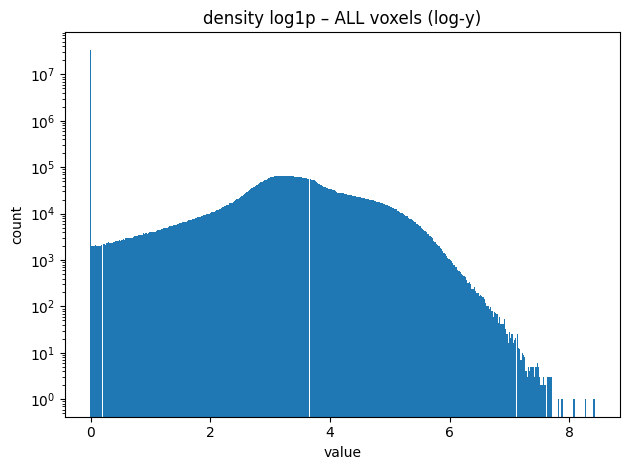

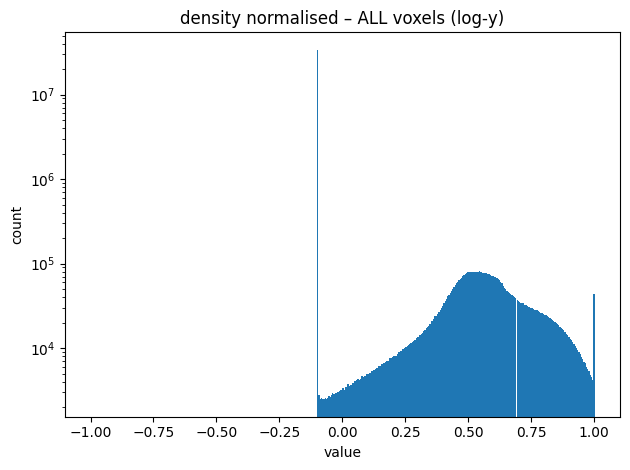

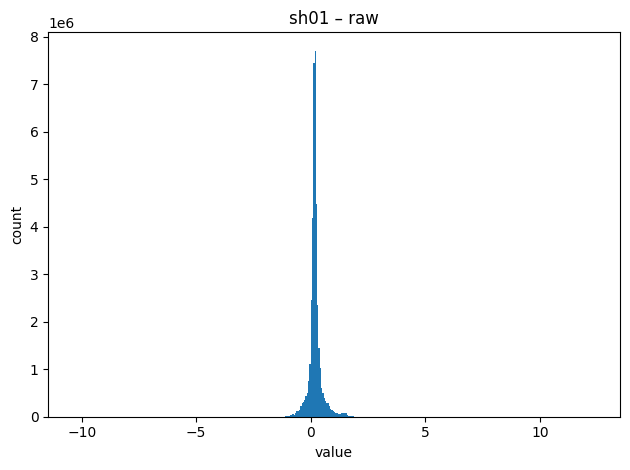

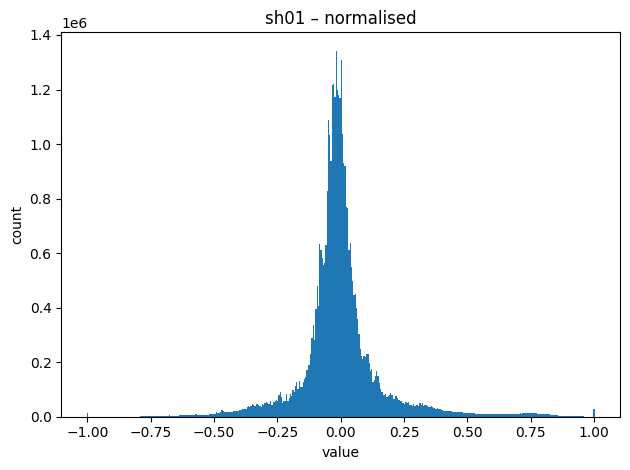

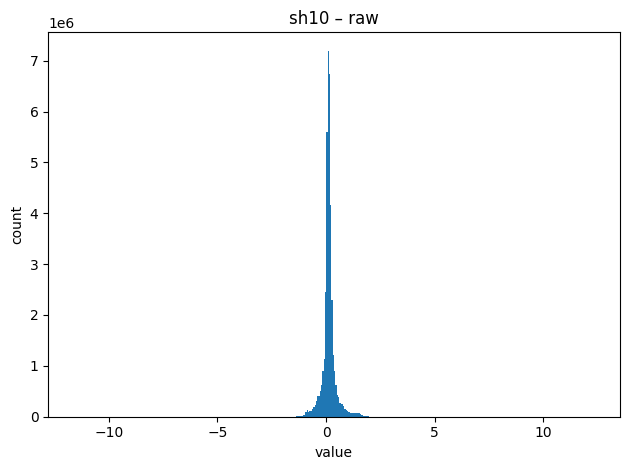

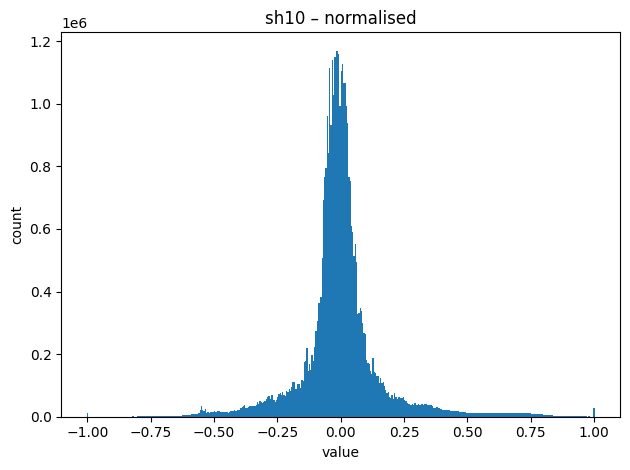

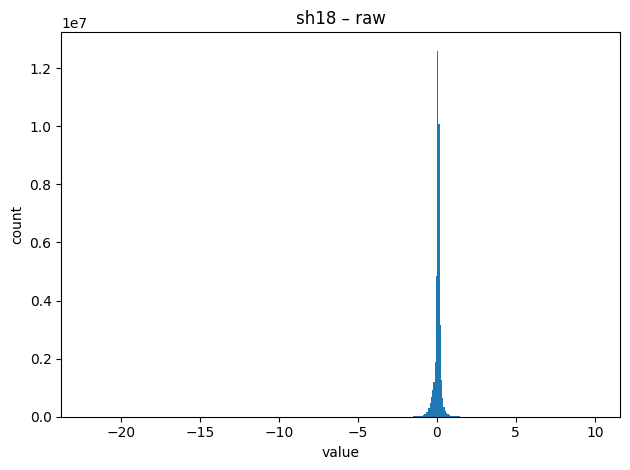

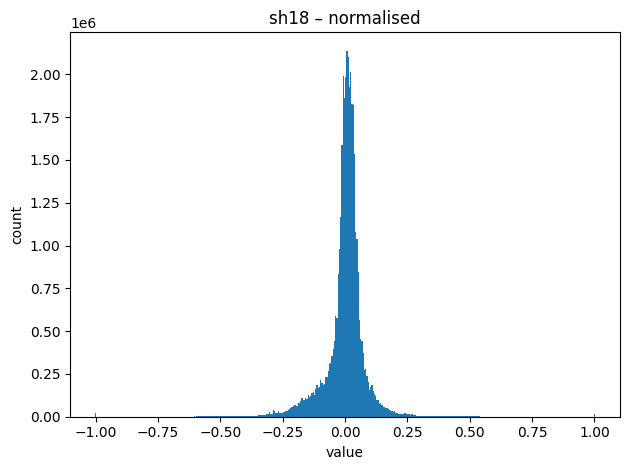

In [40]:
#!/usr/bin/env python3
"""
voxel_normalise.py  –  everything EXCEPT building norm_stats.pt
────────────────────────────────────────────────────────────────
• normalise(grid)    -> values in [-1,1]
• denormalise(grid)  -> original scale
• VoxelDataset(root) -> PyTorch Dataset yielding normalised tensors
• plot_histograms()  -> quick visual check (density + 3 SH channels)
"""

import torch, numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# ───────────────────────── CONFIG ────────────────────────────
CKPT_ROOT = "/weka/scratch/weka/tenenbaum/akiruga/svox2/data/ckpts/shapenet_chairs_all_jupyter"          # set to your folder
STATS_PTH = "norm_stats.pt"           # produced earlier
SH_IDX    = [1, 10, 18]               # which SH to plot
BINS      = 400
SAMPLE    = 20_000                    # voxels per file (histograms)
# ─────────────────────────────────────────────────────────────

# ---------- load μ, σ, amax ----------
stats = torch.load(STATS_PTH)
mu, std, amax = stats["mu"], stats["std"], stats["amax"]
N_CH = len(mu)

# ---------- helpers ----------
EPS = 1e-6
def log1p_pos(x): return torch.log1p(x.clamp_min_(0.) + EPS)
def normalise(grid: torch.Tensor) -> torch.Tensor:
    g = grid.view(-1, N_CH).clone()
    g[:, 0] = log1p_pos(g[:, 0])         # density
    g = (g - mu) / std
    g = g / amax                         # scale → mostly [-1,1]
    g.clamp_(-1, 1)                      # optional safety
    return g.view_as(grid)

def denormalise(norm_g: torch.Tensor) -> torch.Tensor:
    g = norm_g.view(-1, N_CH).clone() * amax
    g = g * std + mu
    g[:, 0] = torch.expm1(g[:, 0])       # invert log1p
    return g.view_as(norm_g)

# ---------- minimal Dataset ----------
from torch.utils.data import Dataset
class VoxelDataset(Dataset):
    def __init__(self, root=CKPT_ROOT):
        self.files = sorted(Path(root).rglob("dense_grid.npz"))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        g = torch.from_numpy(np.load(self.files[idx])["dense_grid"]).float()
        return normalise(g)              # ready for diffusion UNet

# ---------- (optional) histogram visualisation ----------
def plot_histograms():
    def plot(vals, title, bins=BINS, rng=None, ylog=False):
        rng = rng or (vals.min().item(), vals.max().item())
        xs  = torch.linspace(*rng, bins)
        hist = torch.histc(vals, bins=bins, min=rng[0], max=rng[1])
        plt.bar(xs, hist, width=(rng[1]-rng[0])/bins)
        if ylog:
            plt.yscale("log")
        plt.title(title)
        plt.xlabel("value")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()


    raw_d, norm_d, raw_sh, norm_sh = [], [], [[] for _ in SH_IDX], [[] for _ in SH_IDX]

    for p in tqdm(sorted(Path(CKPT_ROOT).rglob("dense_grid.npz")), desc="sampling"):
        g = torch.from_numpy(np.load(p)["dense_grid"]).float().view(-1, N_CH)
        if g.size(0) > SAMPLE:
            g = g[torch.randperm(g.size(0))[:SAMPLE]]

        # density
        raw_d.append(log1p_pos(g[:, 0]))
        norm_d.append(normalise(g)[:, 0])

        # SH
        n = normalise(g)
        for i, ch in enumerate(SH_IDX):
            raw_sh[i].append(g[:, ch])
            norm_sh[i].append(n[:, ch])

    raw_d  = torch.cat(raw_d)
    norm_d = torch.cat(norm_d)
    plot(raw_d,  "density log1p – ALL voxels (log‑y)", ylog=True)
    plot(norm_d, "density normalised – ALL voxels (log‑y)", ylog=True, rng=(-1,1))

    names = [f"sh{ch:02d}" for ch in SH_IDX]
    for i, name in enumerate(names):
        r   = torch.cat(raw_sh[i])
        nrm = torch.cat(norm_sh[i])
        plot(r,  f"{name} – raw",             bins=BINS)
        plot(nrm,f"{name} – normalised",      bins=BINS, rng=(-1,1))

# Uncomment to see histograms
plot_histograms()
